# ProdLDA

In [1]:
from octis.preprocessing.preprocessing import Preprocessing
from octis.models.ProdLDA import ProdLDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real
import torch
import numpy as np
import pandas as pd
import string
import os
from wordcloud import WordCloud
from skopt.space.space import Integer, Real
import time
import matplotlib.pyplot as plt
import json
import spacy
from tqdm import tqdm


In [2]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

In [3]:
SMALL = True

if(SMALL):
    data_path = 'data/input_small'
    corpus_path = 'data/input_small/corpus.txt'
    label_path = 'data/input_small/labels.txt'
    embs_path = 'data/input_small/embeddings.pkl'
    proc_path = 'data/processed_small/dataset'
    frac = 0.001
else:
    data_path = 'data/input'
    corpus_path = 'data/input/corpus.txt'
    label_path = 'data/input/labels.txt'
    proc_path = 'data/processed/dataset'
    frac = 0.5

In [4]:
from preprocessing.prod_clean_text import *

## Data Setup and preprocessing

In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
extract_corpus_and_labels_from_songs_csv(csv_input_path = 'data/raw/cleaned_train_lyrics.csv', output_path = data_path,frac=frac)

Corpus has been saved to data/input_small\corpus.txt
Labels have been saved to data/input_small\labels.txt


In [7]:
preprocessor = Preprocessing(lowercase=True,
                             min_df = 10,
                             max_df = 0.85,
                             remove_punctuation=True,
                             punctuation=string.punctuation,
                             remove_numbers=True,
                             lemmatize= True,
                             stopword_list=CUSTOM_STOPWORDS,
                             min_chars=3,
                             min_words_docs=10,
                             language='english',
                             split=True,
                             verbose=True)

In [8]:
# Checks if dataset folder exists in processed, if not it processes the dataset. Otherwise it loads it
if not os.path.exists(proc_path):
    dataset = preprocessor.preprocess_dataset(documents_path = corpus_path,labels_path = label_path)
    dataset.save(proc_path)
else:
    dataset = Dataset()
    dataset.load_custom_dataset_from_folder(proc_path)

In [9]:
dataset.get_metadata()

{'total_documents': 500,
 'vocabulary_length': 410,
 'preprocessing-info': ['lowercase',
  'remove_punctuation',
  'lemmatize',
  'filter words with document frequency lower than 20 and higher than 0.8',
  'filter words with less than 3 character',
  'filter documents with less than 10 words'],
 'last-training-doc': 345,
 'last-validation-doc': 419}

## Metrics

In [10]:
dummy_run = True

if(dummy_run):
    num_iters = 5
    number_of_calls = 2
else:
    num_iters = 50
    number_of_calls = None # Depends on size of search space

In [11]:
td, ch = TopicDiversity(topk=10), Coherence(texts = dataset.get_corpus(), topk=10, measure = 'c_v') # Initialize metric

## Prod LDA model without optimization

In [12]:
N_TOPICS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

#current_device = torch.cuda.current_device()
#print(f"Currently using GPU: {current_device}")
#print(f"GPU Name: {torch.cuda.get_device_name(current_device)}")

Device: cpu


In [13]:
model = ProdLDA(num_topics=N_TOPICS, 
               activation='softplus', 
               dropout=0.2,
               learn_priors=True, 
               batch_size=64, 
               lr=2e-3, 
               momentum=0.99,
               solver='adam', 
               num_epochs=100, 
               reduce_on_plateau=False, 
               prior_mean=0.0,
               prior_variance=None, 
               num_layers=2, 
               num_neurons=100, 
               num_samples=10,
               use_partitions=True)

In [14]:
#output = model.train_model(dataset, hyperparameters=None, top_words=20)

In [15]:
coherence_list_no_opt, topic_diversity_list_no_opt, iters = [], [], num_iters

for i in tqdm(range(num_iters)):
  output = model.train_model(dataset, hyperparameters=None, top_words=20)
  coherence_list_no_opt.append(ch_score := ch.score(output))
  topic_diversity_list_no_opt.append(td_score := td.score(output))

print("Mean coherence: ", np.mean(coherence_list_no_opt), "\nMean topic diversity: ", np.mean(topic_diversity_list_no_opt))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 751.572803442029	Time: 0:00:00.031192
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 717.925708667652	Time: 0:00:00
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 748.6408797554348	Time: 0:00:00.035042
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 718.1211465371622	Time: 0:00:00.011006
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 746.8738620923913	Time: 0:00:00.020637
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 718.6553328230574	Time: 0:00:00
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 736.4430876358696	Time: 0:00:00.031305
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 718.6838048986486	Time: 0:00:00.015576
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 737.4452502264493	Time: 0:00:00.016065
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 718.3604439400337	Time: 0:00:00.016629
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 738.6714730525363	Time: 0:00:00.038091
Epoch: [6/100]	Samples: [74/7400]	Valida

 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 756.6588541666666	Time: 0:00:00.029191
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 717.8590846706081	Time: 0:00:00
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 747.9511039402174	Time: 0:00:00.033121
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 718.0535591744087	Time: 0:00:00
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 741.3413156702899	Time: 0:00:00.045768
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 718.0013130806587	Time: 0:00:00.010125
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 740.7414147418478	Time: 0:00:00.036364
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 718.8433408994932	Time: 0:00:00.001498
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 736.501907835145	Time: 0:00:00.023109
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 717.8365577491554	Time: 0:00:00
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 729.7962692481884	Time: 0:00:00.026758
Epoch: [6/100]	Samples: [74/7400]	Validation L

 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 749.3468297101449	Time: 0:00:00.036738
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 718.9764239336994	Time: 0:00:00.004045
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 741.6865828804348	Time: 0:00:00.028561
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 719.0924105257601	Time: 0:00:00.008191
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 746.4501528532609	Time: 0:00:00.062421
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 719.379321948902	Time: 0:00:00.008710
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 729.8764945652174	Time: 0:00:00.038633
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 720.5411607896959	Time: 0:00:00.003993
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 728.8072180706522	Time: 0:00:00.043961
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 721.2337019636824	Time: 0:00:00.009741
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 723.5815104166667	Time: 0:00:00.057961
Epoch: [6/100]	Samples: [

 60%|██████    | 3/5 [00:07<00:04,  2.29s/it]

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 750.8698312952898	Time: 0:00:00.013808
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 717.871067356419	Time: 0:00:00.015623
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 739.4382048233696	Time: 0:00:00.031277
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 718.0410948057432	Time: 0:00:00.007232
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 737.0822690217391	Time: 0:00:00.013894
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 718.3913112331081	Time: 0:00:00
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 734.3917119565217	Time: 0:00:00.030132
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 718.855686497044	Time: 0:00:00.015621
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 730.4799026268116	Time: 0:00:00.015833
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 719.2658889358108	Time: 0:00:00
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 728.4477836277174	Time: 0:00:00.040785
Epoch: [6/100]	Samples: [74/7400]	Valida

 80%|████████  | 4/5 [00:08<00:01,  1.75s/it]

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 748.3500226449275	Time: 0:00:00.028902
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 717.9624617293074	Time: 0:00:00
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 757.9297950634058	Time: 0:00:00.036194
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 717.8060995565878	Time: 0:00:00.004549
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 744.4164685235507	Time: 0:00:00.024134
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 718.0748719911318	Time: 0:00:00
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 738.7992300724637	Time: 0:00:00.041453
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 718.8034206081081	Time: 0:00:00
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 738.8316462862318	Time: 0:00:00.034775
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 719.3359375	Time: 0:00:00.003987
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 731.4458106884058	Time: 0:00:00.025831
Epoch: [6/100]	Samples: [74/7400]	Validation Loss: 

100%|██████████| 5/5 [00:09<00:00,  1.82s/it]

Mean coherence:  0.30750830940034224 
Mean topic diversity:  0.7140000000000001


## Prod LDA model with optimization

In [16]:
model = ProdLDA()

In [17]:
# Define the search space. To see which hyperparameters to optimize, see the topic model's initialization signature
search_space = {"num_topics": Integer(low=5, high=50),
                "dropout": Real(low=0.2, high=0.5),
                "lr": Real(low=1e-3, high=0.01),} #TODO: possibly add num_layers, num_neurons to search space

# Initialize an optimizer object and start the optimization.
optimizer=Optimizer()

if(number_of_calls == None):
    number_of_calls = len(search_space.keys())*5


print(number_of_calls)

2


In [18]:
start = time.time() # Just to see, to be removed.

# This uses the default optimization method (Bayesian optimization) and the default metric (coherence) to optimize the model, try also random search.

optResult=optimizer.optimize(model, dataset, ch, search_space, save_path="results/test_ProdLDA", # path to store the results
                            number_of_call=number_of_calls, # number of optimization iterations: rule of thumb 15*num_hyperparameters but takes a lot of time so 30 instead
                            model_runs= num_iters, # number of runs of the topic model: can be increased but takes more time
                            plot_best_seen=True, # plot the best seen value of the metric
                            extra_metrics = [td],
                            plot_model=True, # plot the topic model
                            early_step=10, # number of iterations after which the optimization stops if no improvement
                            surrogate_model='GP', # surrogate model for the optimization: gaussian process
                            random_state=123,
                            save_models = True,
                            topk=20)

#save the results of th optimization in a csv file
optResult.save_to_csv("results.csv")

end = time.time()
duration = end - start

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')
results = json.load(open("results/test_ProdLDA/result.json",'r'))

Current call:  0
Epoch: [1/100]	Samples: [345/34500]	Train Loss: 759.7348845108696	Time: 0:00:00.033791
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 719.2755819784628	Time: 0:00:00.013237
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 742.7035665760869	Time: 0:00:00.028655
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 723.6488070101351	Time: 0:00:00.006218
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 751.0346127717391	Time: 0:00:00.028246
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 724.425754856419	Time: 0:00:00
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 739.9670516304348	Time: 0:00:00.037365
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 726.2129038217905	Time: 0:00:00.001733
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 725.4418817934783	Time: 0:00:00.026386
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 728.6856986380913	Time: 0:00:00
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 715.7341513813406	Time: 0:00:00.041063
Epoch: [6/100]	Samples

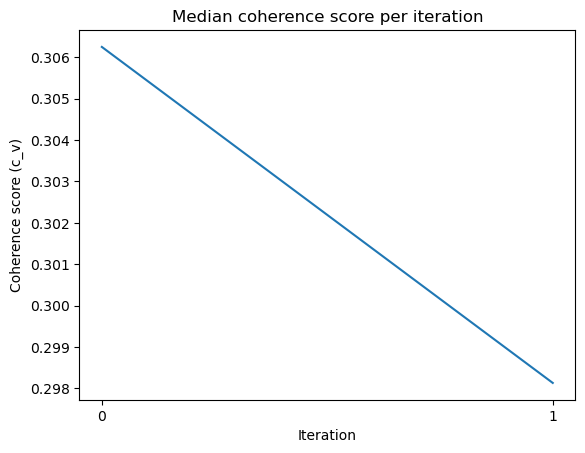

In [19]:
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Median coherence score per iteration')
plt.plot(results["f_val"])
plt.xticks(range(len(results["f_val"])))
plt.show()

In [20]:
max_index = results["f_val"].index(max(results["f_val"]))
print(results["f_val"][max_index])


0.3062503643580915


In [21]:
print(results["x_iters"].keys())

num_topics = results["x_iters"]["num_topics"][max_index]
dropout = results["x_iters"]["dropout"][max_index]
lr = results["x_iters"]["lr"][max_index]

print("Optimal number of topics: ", num_topics)
print("Optimal dropout: ", dropout)
print("Optimal learning rate: ", lr)

dict_keys(['dropout', 'lr', 'num_topics'])
Optimal number of topics:  16
Optimal dropout:  0.41840902737637237
Optimal learning rate:  0.006313971035362703


In [22]:
model = ProdLDA(num_topics=num_topics, dropout=dropout, lr=lr)

In [23]:
coherence_list, topic_diversity_list, iters = [], [], num_iters

for i in range(iters):
  output = model.train_model(dataset, top_words=20)
  coherence_list.append(ch_score := ch.score(output))
  topic_diversity_list.append(td_score := td.score(output))



print("Mean coherence: ", np.mean(coherence_list), "\nMean topic diversity: ", np.mean(topic_diversity_list))

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 749.9767210144928	Time: 0:00:00.034367
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 726.7816459037163	Time: 0:00:00.012503
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 753.336277173913	Time: 0:00:00.034432
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 729.8665936444256	Time: 0:00:00.007127
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 743.0174818840579	Time: 0:00:00.032301
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 728.7519135346283	Time: 0:00:00.003986
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 724.4606657608696	Time: 0:00:00.025402
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 729.6755041173986	Time: 0:00:00.003987
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 715.9742583786232	Time: 0:00:00.030092
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 727.0678644953547	Time: 0:00:00.003987
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 722.7697067481884	Time: 0:00:00.031683
Epoch: [6/100]	Samples: [

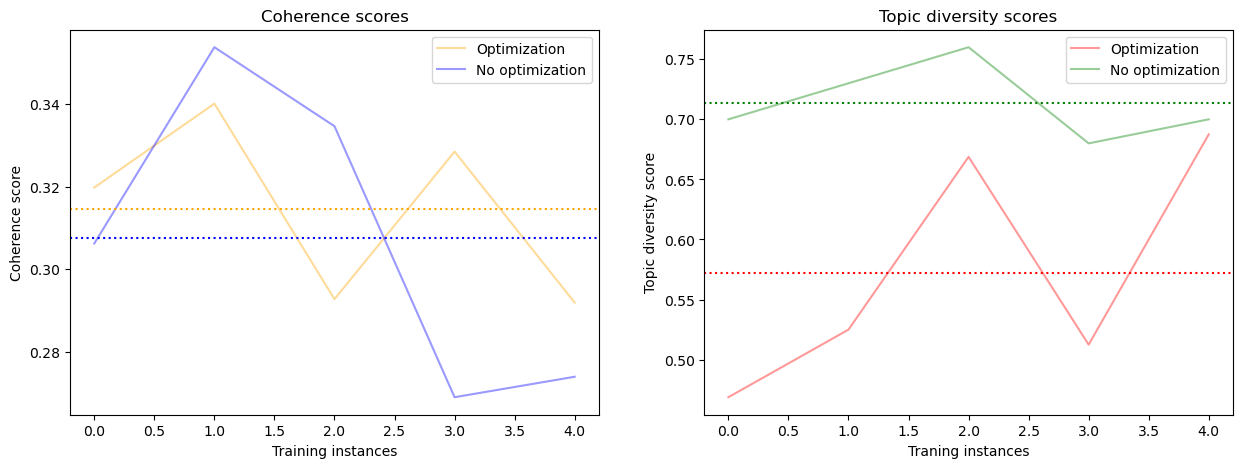

In [24]:

# Plot of the coherences of the models (no opt vs opt) and the topic diversity of the models (no opt vs opt). Both plots also show the mean values and the variance!
# Two plots side by side 

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Coherence scores plot
axs[0].plot(coherence_list, label="Optimization", color = 'orange', alpha = 0.4)
axs[0].plot(coherence_list_no_opt, label="No optimization", color = 'blue', alpha = 0.4)
axs[0].axhline(y=np.mean(coherence_list), color='orange', linestyle=':')
axs[0].axhline(y=np.mean(coherence_list_no_opt), color='blue', linestyle=':')
axs[0].set_title("Coherence scores")
axs[0].set_xlabel("Training instances")
axs[0].set_ylabel("Coherence score")
axs[0].legend()

# Topic diversity scores plot
axs[1].plot(topic_diversity_list, label="Optimization", color = 'r', alpha = 0.4)
axs[1].plot(topic_diversity_list_no_opt, label="No optimization", color = 'g', alpha = 0.4)
axs[1].axhline(y=np.mean(topic_diversity_list), color='r', linestyle=':')
axs[1].axhline(y=np.mean(topic_diversity_list_no_opt), color='g', linestyle=':')
axs[1].set_title("Topic diversity scores")
axs[1].set_xlabel("Traning instances")
axs[1].set_ylabel("Topic diversity score")
axs[1].legend()

plt.show()




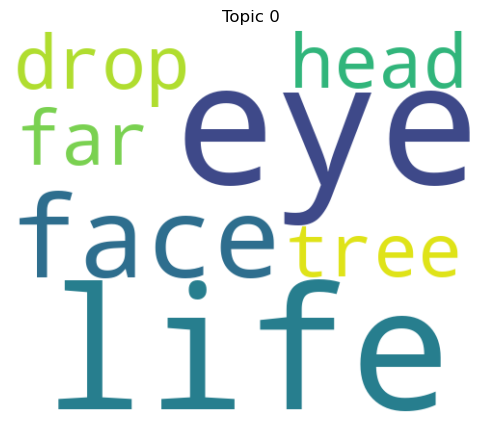

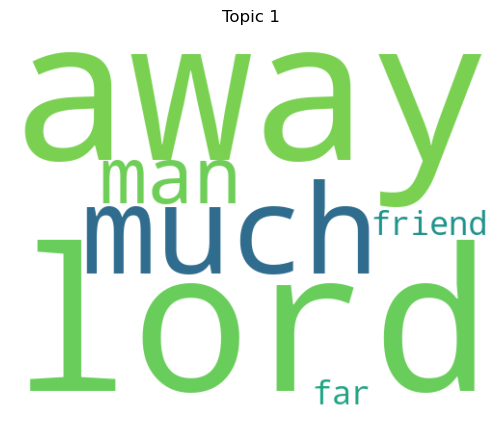

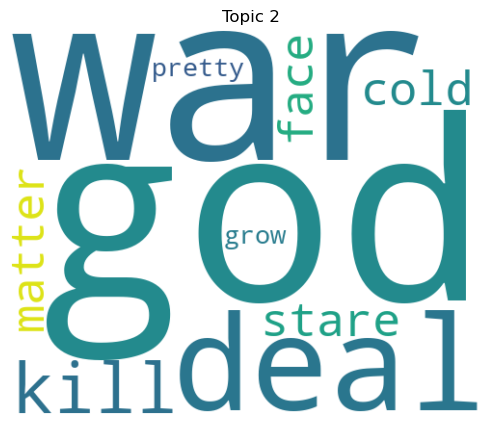

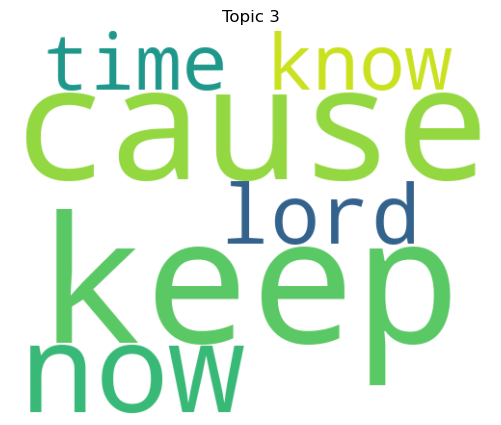

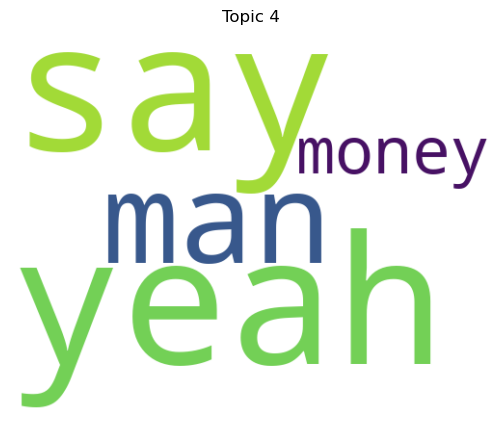

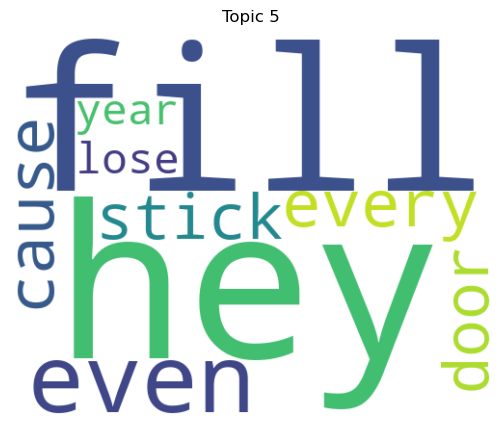

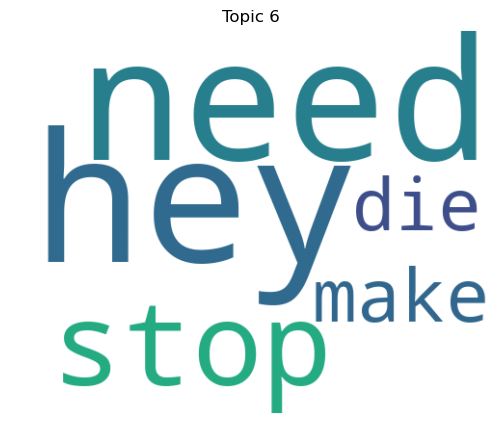

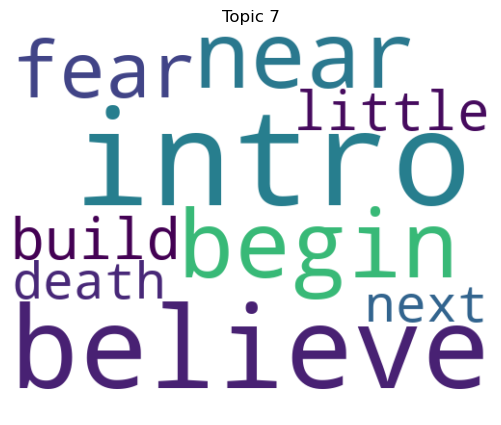

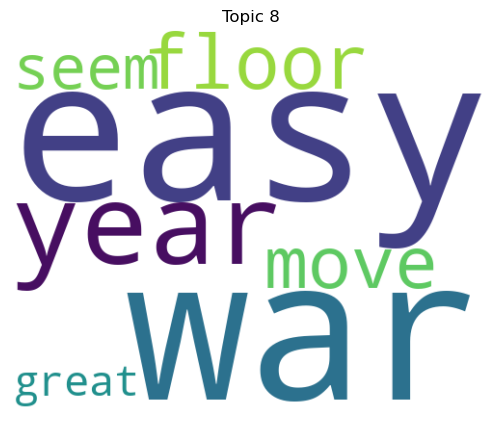

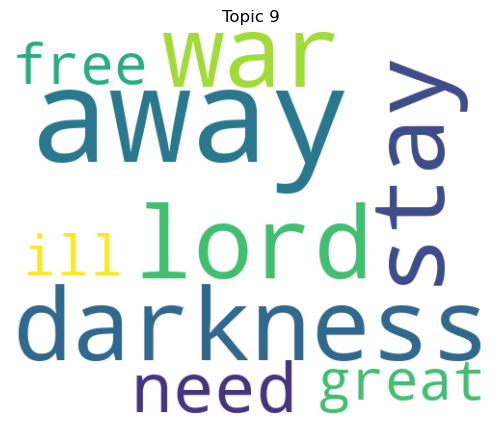

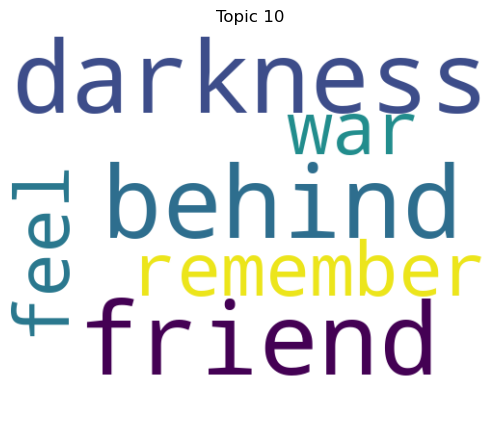

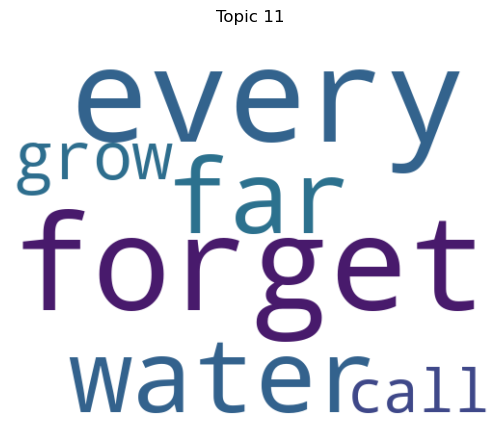

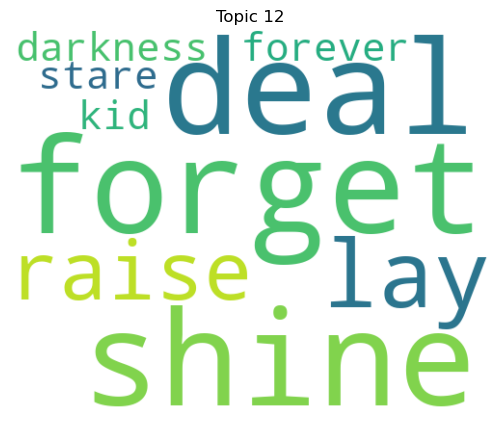

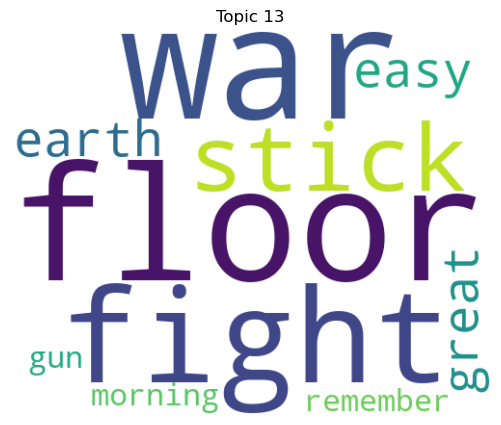

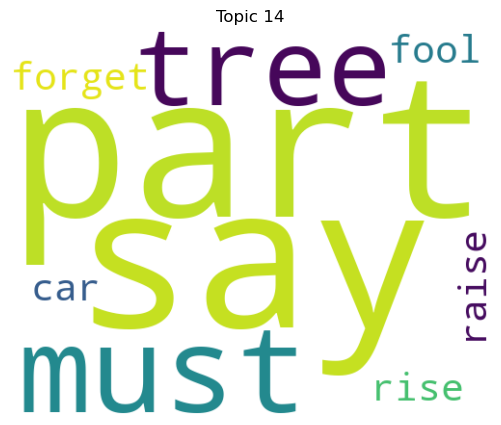

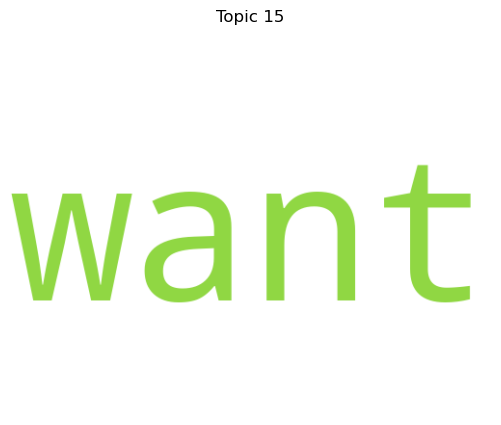

In [25]:
topics = output['topics']
for i, topic in enumerate(topics):
  wordcloud = WordCloud(width=500, height=400, background_color='white').generate(" ".join(topic))
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Topic {i}")
  plt.show()

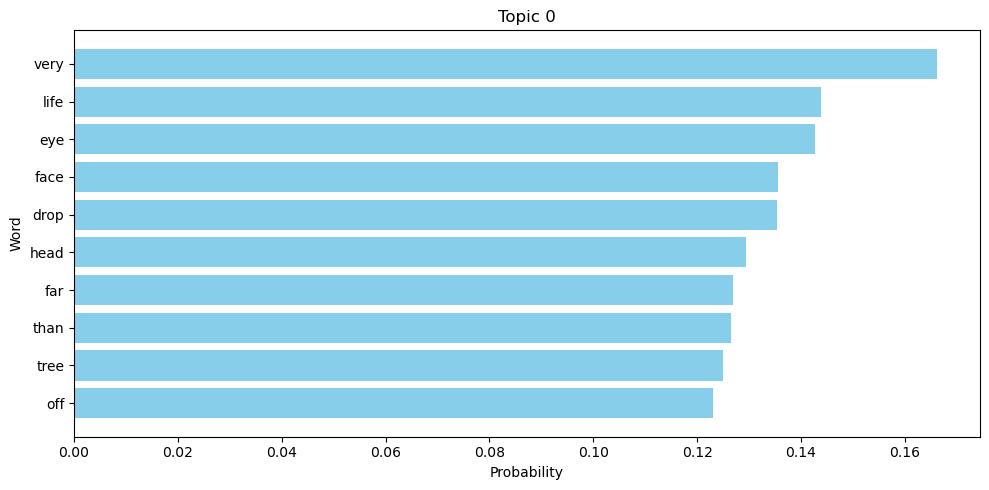

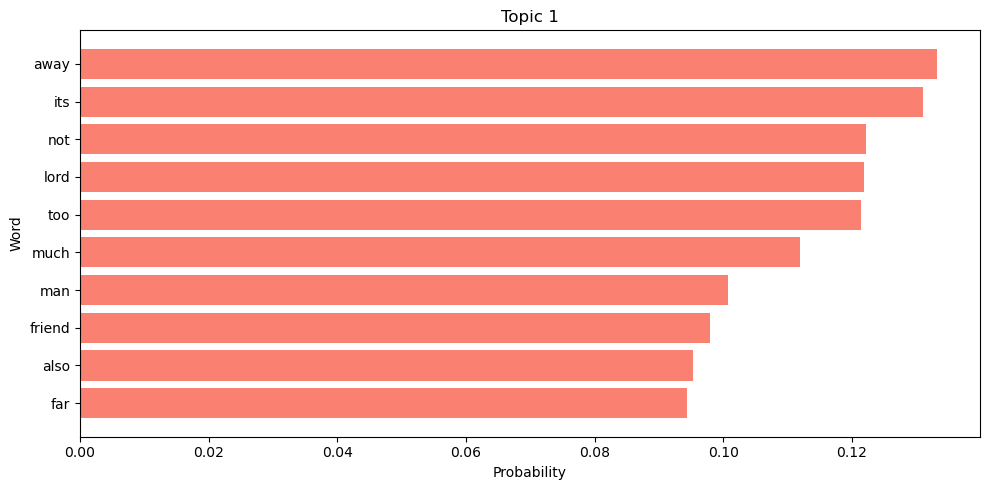

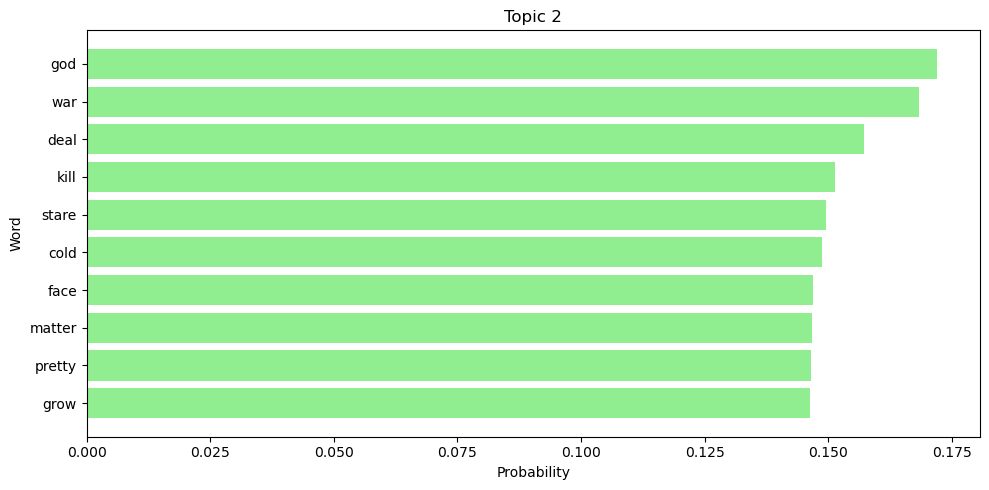

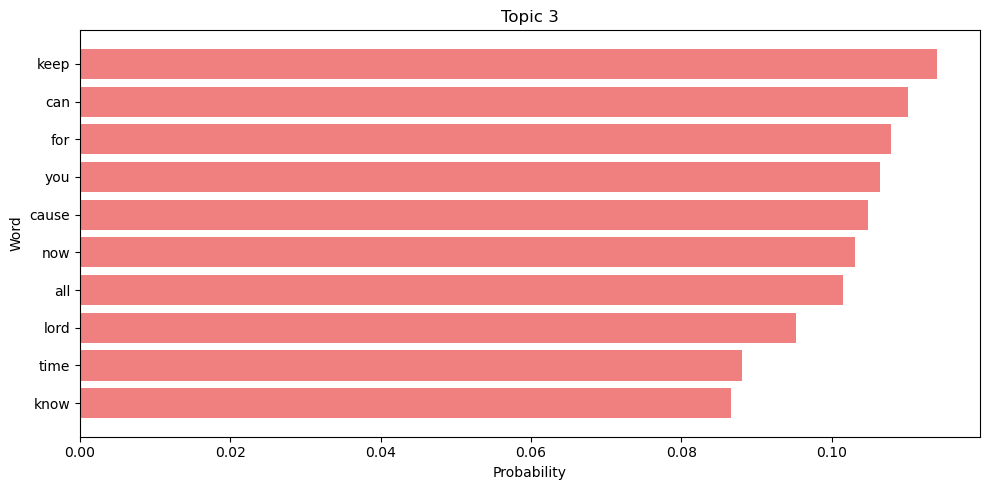

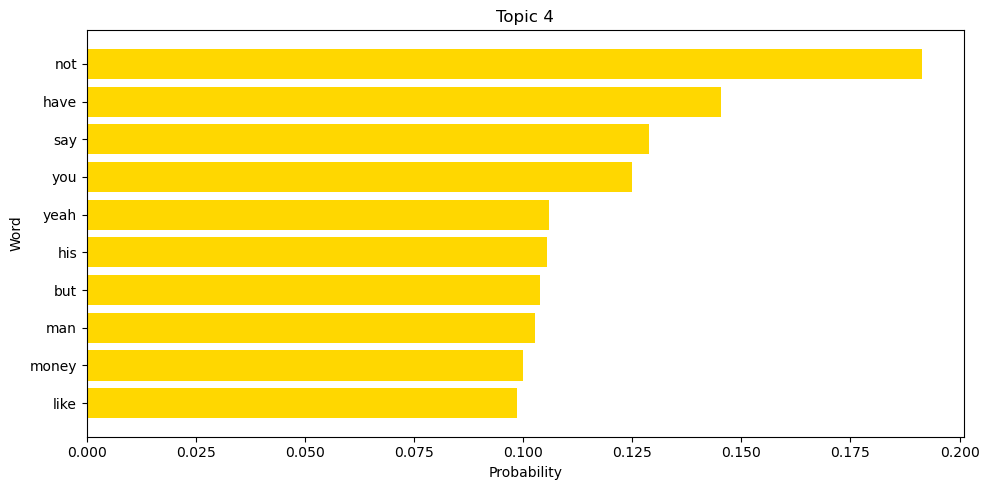

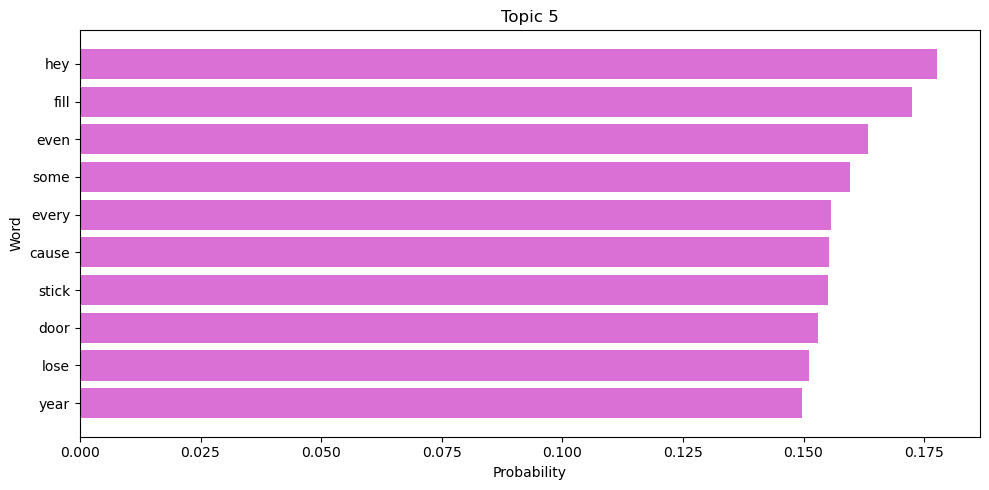

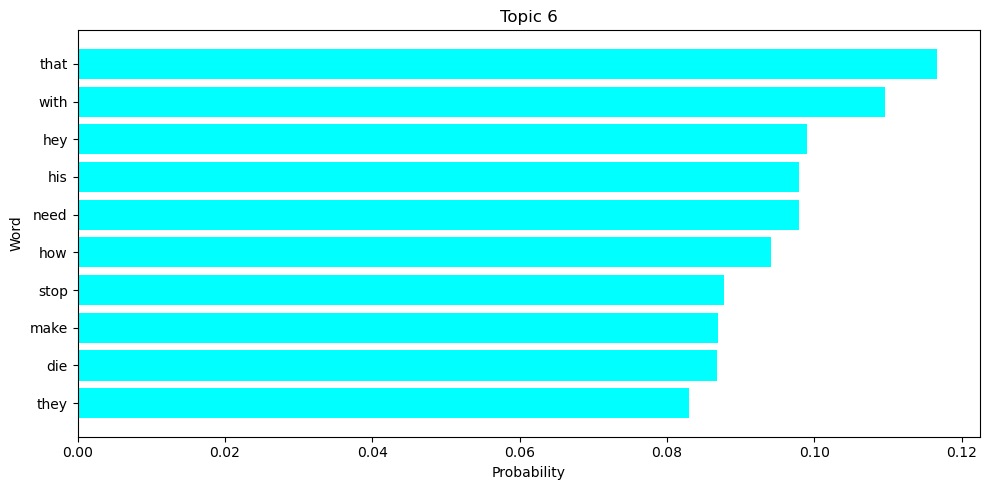

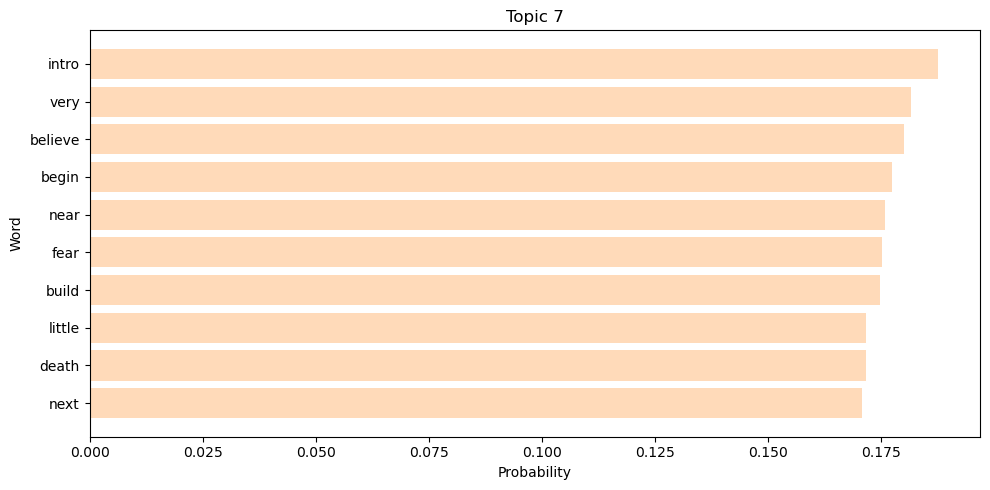

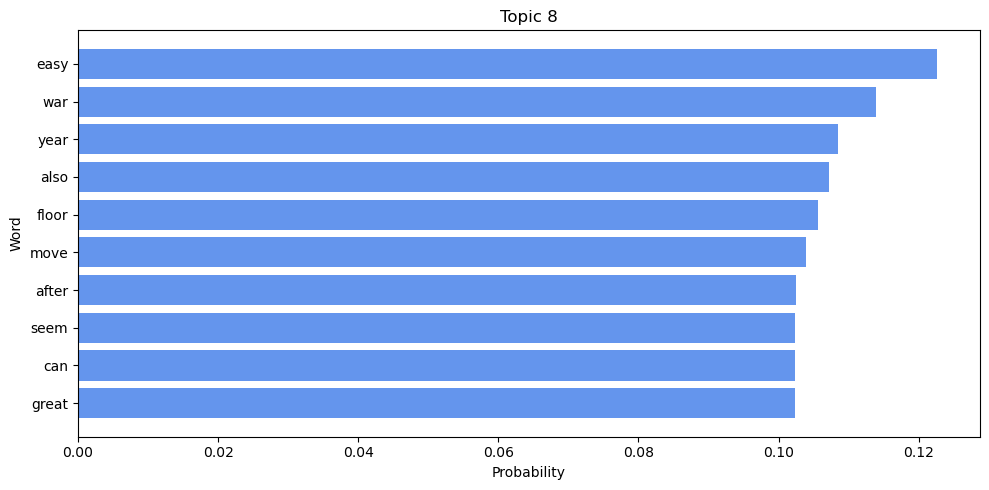

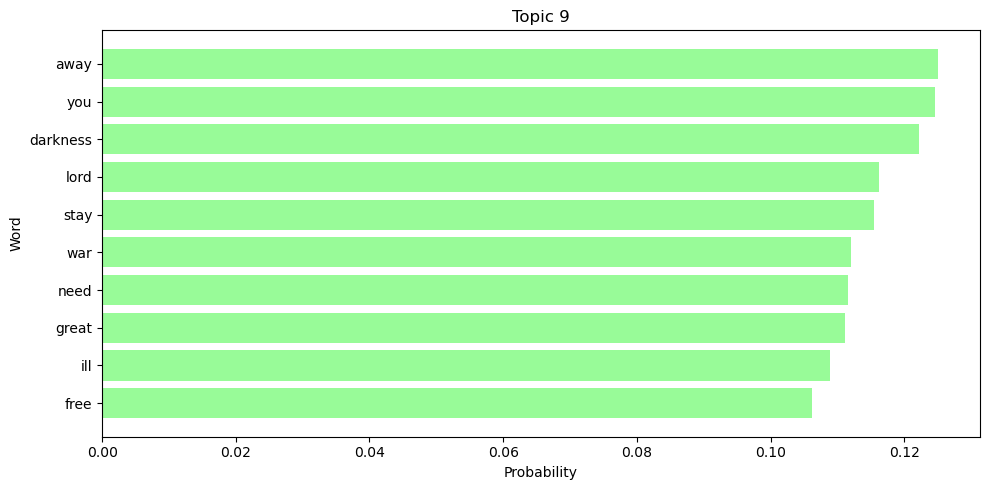

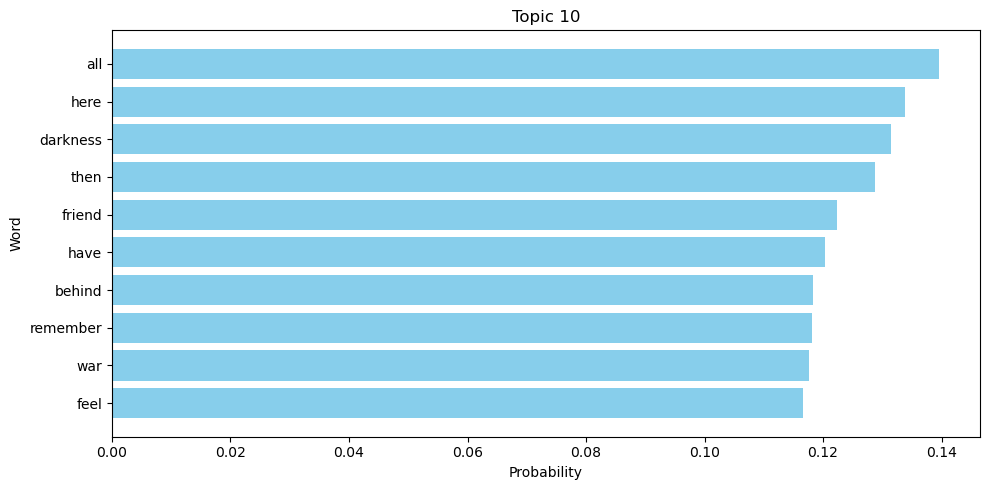

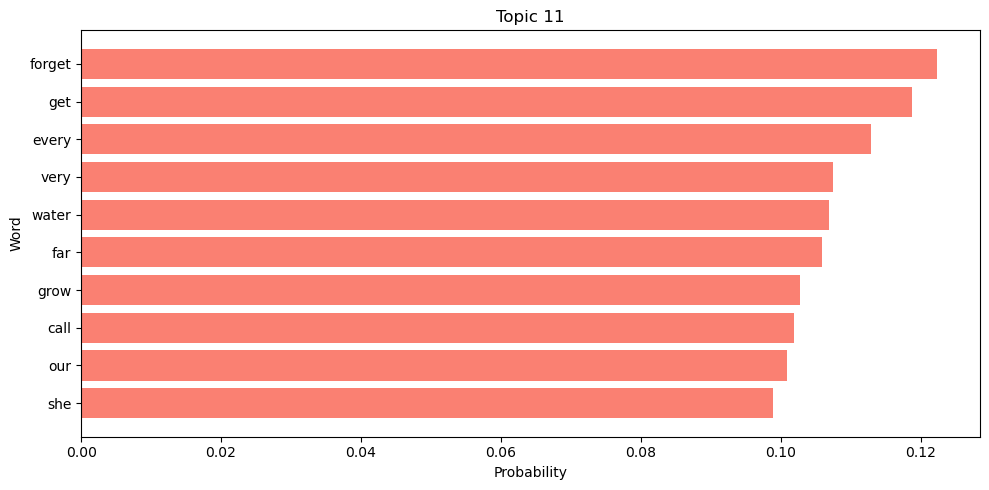

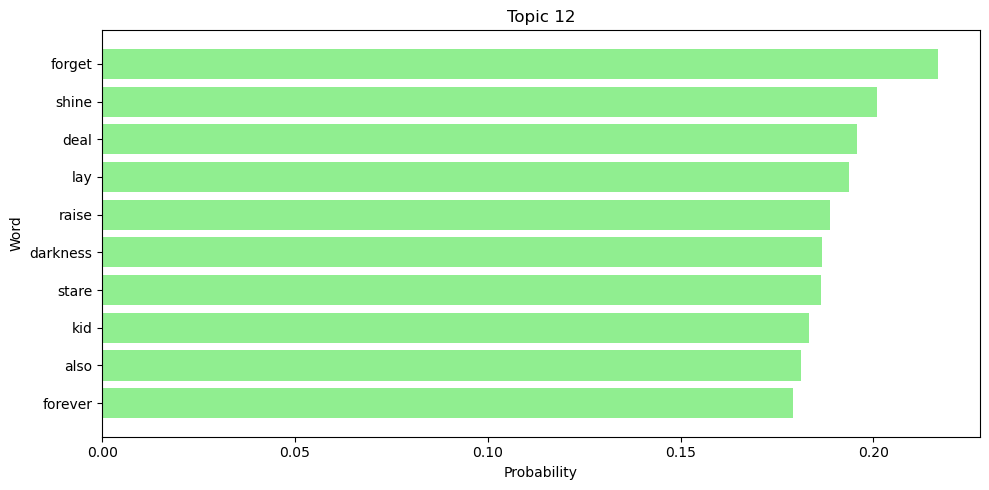

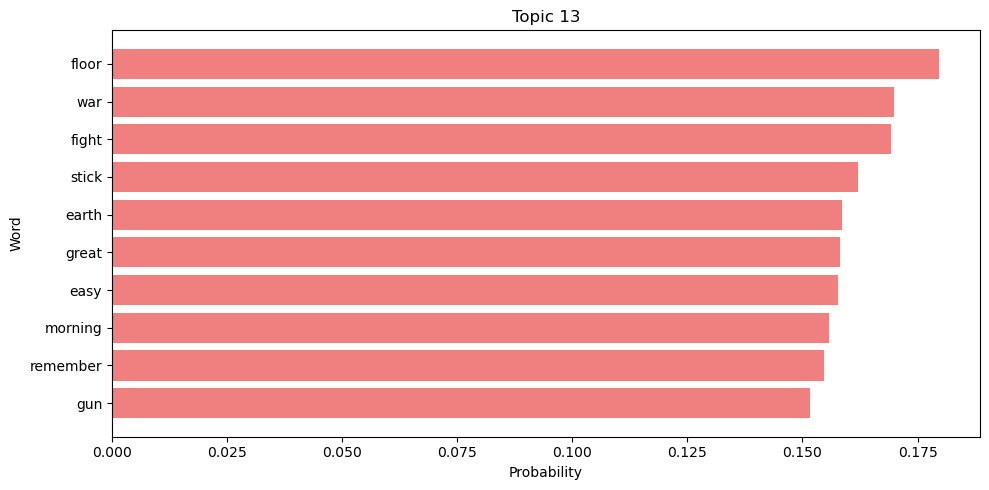

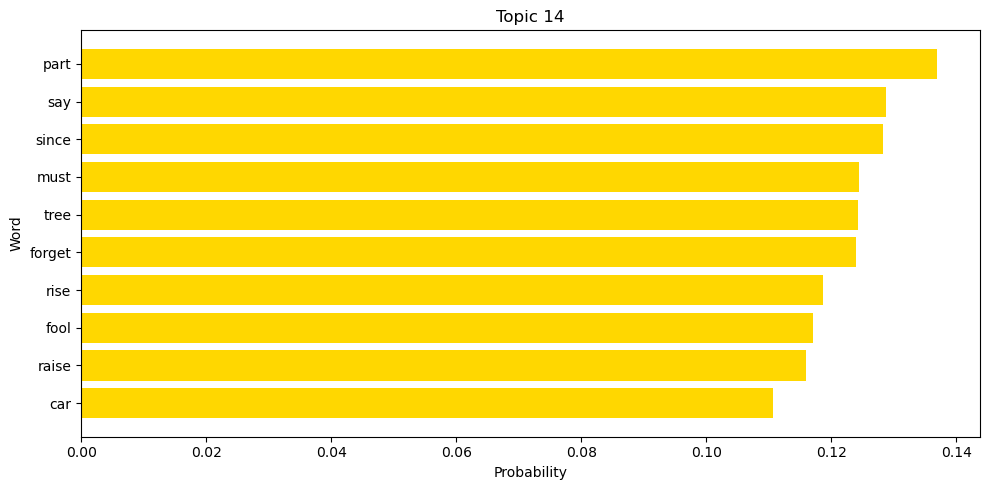

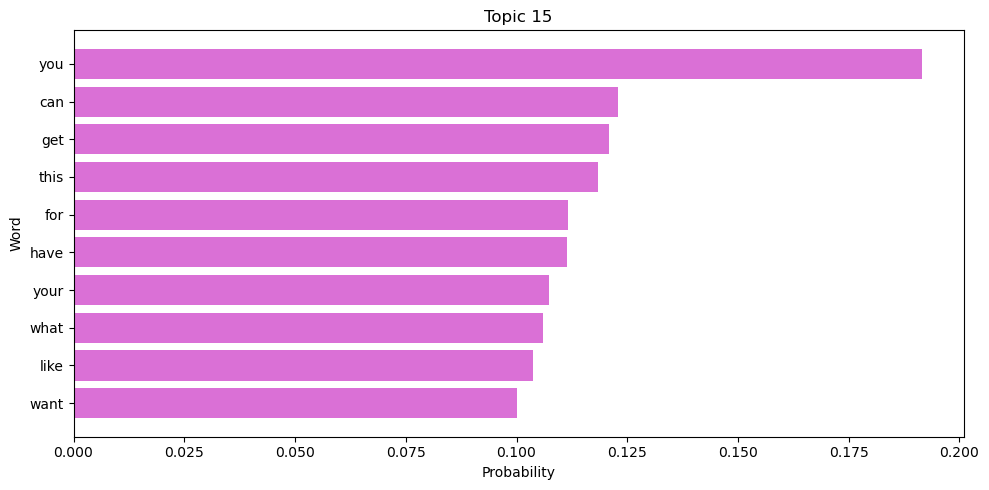

In [26]:
topic_word_matrix = output['topic-word-matrix']
words = output['topics'] # List of all words in the vocabulary


# Number of words to display 
top_n_words = 10

colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'gold', 'orchid', 'cyan', 'peachpuff', 'cornflowerblue', 'palegreen']

# Display the top n words for each topic in a bar plot
for i, topic in enumerate(topic_word_matrix):
    # Get the top N words and their probabilities
    top_n_words_indices = np.argsort(topic)[::-1][:top_n_words]
    top_n_words_values = [topic[i] for i in top_n_words_indices]
    top_n_words_words = words[i]

    # Use a different color for each topic
    color = colors[i % len(colors)]  # Cycle through the list of colors

    # Create horizontal bar plot
    plt.figure(figsize=(10, 5))
    plt.barh(top_n_words_words, top_n_words_values, color=color)
    plt.xlabel("Probability")
    plt.ylabel("Word")
    plt.title(f"Topic {i}")
    
    # Invert y-axis for readability
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()